# Psyplot with cfgrib

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib widget

In [65]:
import psyplot.project as psy

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from IPython.display import display, Video

from ipympl.backend_nbagg import Canvas
Canvas.header_visible.default_value = False

import warnings
warnings.filterwarnings("ignore", r"\s*The on_mappable_changed")
warnings.filterwarnings("ignore", r"\s*The input coordinates")
warnings.filterwarnings("ignore", r"\s*shading=")
warnings.filterwarnings("ignore", r"\s*\[Warning by")
warnings.filterwarnings("ignore", r"\s*ShapelyDeprecationWarning")

In [4]:
f_icon_irr = '/scratch/walser/icon-vis/icon-1/21112300.grb2/lfff00000000'
f_icon_reg = '/store/s83/tsm/ICON-1E/FCST21/21112300_606/grib/i1effsurf000_001'
f_cosmo = '/store/s83/osm/KENDA-1/ANA21/det/laf2021112300'

gridfile='/scratch/cmerker/data/icon_grid/icon_grid_0001_R19B08_L.nc'


## 1.0 Open GRIB2 file with gridfile argument in psy.open_dataset - doesn't appear to work.

In [5]:
ds_cfgrib_withgridfile = psy.open_dataset(f_icon_irr, decode_cf=True, gridfile=gridfile, engine='cfgrib',  backend_kwargs={'indexpath': '', 'errors': 'ignore'})

#### Encoding.coordinates is not correct and so won't plot lon and lat on the axis.

In [6]:
ds_cfgrib_withgridfile.t2m.encoding

{'source': '/scratch/walser/icon-vis/icon-1/21112300.grb2/lfff00000000',
 'filter_by_keys': {},
 'encode_cf': ('parameter', 'time', 'geography', 'vertical'),
 'original_shape': (1028172,),
 'dtype': dtype('float32'),
 'coordinates': 'number time step heightAboveGround valid_time'}

In [7]:
#figure1 = ds_cfgrib_withgridfile.psy.plot.mapplot(
#    name="t2m", xgrid='None',  ygrid='None'
#)

## 2.0 Open GRIB2 file using psy.open_dataset with cfgrib engine

In [8]:
ds_cfgrib = psy.open_dataset(f_icon_irr, engine='cfgrib',  backend_kwargs={'indexpath': '', 'errors': 'ignore'})

## 2.1 Open the corresponding R19B08 Grid for the GRIB file:
(No engine neeeded, engine only needed for grid files.)

In [9]:
ds_grid = psy.open_dataset(gridfile)

## 2.2 Combine GRID file with GRIB2 file, to have coordinates from GRID file with the GRIB data.

In [10]:
def openfiles(file, gridfile):
    ds_cfgrib = psy.open_dataset(file, engine='cfgrib',  backend_kwargs={'indexpath': '', 'errors': 'ignore'})
    ds_grid = psy.open_dataset(gridfile)
    return ds_cfgrib, ds_grid

In [11]:
# TODO: remove a lot of the un-needed steps in this function since these were experimental, 
# and now we know they are not all required for the plots.

def combine_grib_grid(file, grid):
    
    result = file.rename({'time': 'init_time','valid_time': 'time'}
                        ).rename_dims({'values':'ncells'}
                        ).assign_coords(
                        clon=('ncells', np.float32(grid.coords['clon'].values))
                        ).assign_coords(
                        clat=('ncells', np.float32(grid.coords['clat'].values))
                        ).assign_coords(
                        clat_bnds=(('ncells','vertices'), np.float32(grid.coords['clat_vertices'].values))
                        ).assign_coords(
                        clon_bnds=(('ncells','vertices'), np.float32(grid.coords['clon_vertices'].values))
                        ).expand_dims('time')
    
    result.clon.attrs['standard_name']='longitude'
    result.clon.attrs['long_name']='center longitude'
    result.clon.attrs['units']='radian'
    result.clon.attrs['bounds']='clon_bnds'
    result.clat.attrs['standard_name']='latitude'
    result.clat.attrs['long_name']='center latitude'
    result.clat.attrs['units']='radian'
    result.clat.attrs['bounds']='clat_bnds'

    result.time.attrs['axis']='T'
    result.generalVerticalLayer.attrs['positive']='up'
    result.generalVerticalLayer.attrs['axis']='Z'
    
    return result

In [12]:
ds_cfgrib, ds_grid = openfiles(f_icon_irr, gridfile)
ds_cfgrib_combi = combine_grib_grid(ds_cfgrib, ds_grid)

#### Simplified merging shown below

In [13]:
#ds = psy.open_dataset("t2m.grb", engine="cfgrib")
#grid_ds = psy.open_dataset("ICON-1E_DOM01.nc")
#merged = ds.rename({"values": "cell"}).merge(grid_ds)
#merged.t2m.encoding["coordinates"] += " clon clat"

### Coordinate encoding of variables remains incorrect, must be corrected.

In [14]:
print(ds_cfgrib_combi.t.encoding['coordinates'])

number time step generalVerticalLayer valid_time


In [15]:
ds_cfgrib_combi.t.encoding['coordinates'] = 'clon clat'
print(ds_cfgrib_combi.t.encoding['coordinates'])

clon clat


In [16]:
import six

def add_encoding(obj):
    obj.encoding['coordinates'] = 'clat clon'
    
for k, v in six.iteritems(ds_cfgrib_combi.data_vars):
    add_encoding(v)

### Now the variables are ready to be plotted.

In [17]:
ds_cfgrib_combi

<xarray.Dataset>
Dimensions:               (ncells: 1028172, generalVerticalLayer: 80, depthBelowLandLayer: 8, depthBelowLand: 9, generalVertical: 81, vertices: 3, time: 1)
Coordinates: (12/25)
    number                int64 ...
    init_time             datetime64[ns] ...
    step                  timedelta64[ns] ...
    surface               float64 ...
  * time                  (time) datetime64[ns] 2021-11-23
    isobaricLayer         float64 ...
    ...                    ...
  * depthBelowLand        (depthBelowLand) float64 0.0 0.005 0.02 ... 4.86 14.58
  * generalVertical       (generalVertical) float64 1.0 2.0 3.0 ... 80.0 81.0
    clon                  (ncells) float32 -0.003694 -0.003783 ... 0.2608 0.2607
    clat                  (ncells) float32 0.8636 0.8635 0.8632 ... 0.868 0.8679
    clat_bnds             (ncells, vertices) float32 0.8635 0.8637 ... 0.8678
    clon_bnds             (ncells, vertices) float32 -0.003566 ... 0.2605
Dimensions without coordinates: ncells, vertices
Data variables: (12/70)
    snfalb                (time, ncells) float32 0.07 0.07 ... 0.1171 0.1179
    lhtfl                 (time, ncells) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    nlwrf                 (time, ncells) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    dlwrf                 (time, ncells) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ulwrf                 (time, ncells) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    shtfl                 (time, ncells) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...                    ...
    sd                    (time, ncells) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    W_SO                  (time, depthBelowLandLayer, ncells) float32 0.0 ......
    W_SO_ICE              (time, depthBelowLandLayer, ncells) float32 0.0 ......
    wz                    (time, generalVertical, ncells) float32 -0.009946 ....
    THHR_RAD              (time, generalVerticalLayer, ncells) float32 1.237e...
    SOHR_RAD              (time, generalVerticalLayer, ncells) float32 0.0 .....
Attributes:
    GRIB_edition:            2
    GRIB_centre:             lssw
    GRIB_centreDescription:  Zurich
    GRIB_subCentre:          255
    Conventions:             CF-1.7
    institution:             Zurich
    history:                 2022-01-25T16:18 GRIB to CDM+CF via cfgrib-0.9.9...

/scratch/vcherkas/envs/psyplot/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/scratch/vcherkas/envs/psyplot/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/scratch/vcherkas/envs/psyplot/lib/python3.8/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


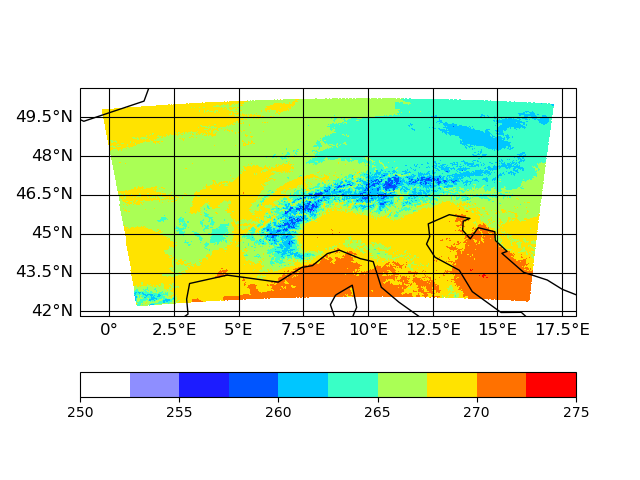

In [18]:
newfigure2_2 = ds_cfgrib_combi.psy.plot.mapplot(
    name="t", generalVerticalLayer=50, time=0
)

In [19]:
# newfigure.update(datagrid={'c': 'k', 'lw': 0.1})
newfigure2_2.update(cmap='Reds', datagrid=None, xgrid='None',  ygrid='None')
newfigure2_2.update(clabel='{desc}')
newfigure2_2.update(title=(f"{ds_cfgrib_combi.t.attrs['GRIB_name']} on "
                        f"{ds_cfgrib_combi.t.attrs['GRIB_typeOfLevel']} " 
                        f"%({ds_cfgrib_combi.t.attrs['GRIB_typeOfLevel']})s "
                        f"at %(time)s ")
                )

/scratch/vcherkas/envs/psyplot/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/scratch/vcherkas/envs/psyplot/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/scratch/vcherkas/envs/psyplot/lib/python3.8/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


## 3.0 Custom Plotter and FormatOptions

In [20]:
from psyplot.plotter import Formatoption
import psyplot.project as psy

from psy_simple.plotters import CMap, Bounds
from psy_maps.plotters import Transform, MapPlot2D, LonLatBox, MapPlotter
from psyplot.plotter import Plotter
import psy_simple.plotters
import psy_maps.plotters
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

### Borders Formatoption

In [21]:
import cartopy.feature as cf;
class Borders(Formatoption):
    """Draw borders on a map"""
    
    default = {'color': 'black', 'linewidth': 0.0}

    def validate(self, value):
        if type(value) is dict:
            return value
        else:
            return bool(value)

    def update(self, value):
        if type(value) is dict:
            self.borders = self.ax.add_feature(cf.BORDERS, color=value['color'], linewidth=value['linewidth'])
        elif value is True:
            self.borders = self.ax.add_feature(cf.BORDERS, color='black', linewidth=1.0)
        else:
            if hasattr(self, "borders"):
                self.borders.remove()
                del self.borders

In [22]:
psy.plot.mapplot.plotter_cls.borders = Borders("borders")

### Custom Text Formatoption

In [23]:
class CustomText(Formatoption):
    
    #: the default value for the formatoption
    default = 'initial value'
    
    def initialize_plot(self, value):
        # method initialize the plot in the very beginning
        self.text = self.ax.text(0., -0.15, 
                                 value, 
                                 fontsize="xx-large", 
                                 # ha='right', va='top',   # text alignment,
                                 transform=self.ax.transAxes      # coordinate system transformation)
        )
        
    def update(self, value):
        # method to update the plot
        self.text.set_text(value)

In [24]:
psy.plot.mapplot.plotter_cls.customtext = CustomText("customtext")

### Custom Lakes and Rivers Formatoption

In [25]:
from cartopy.feature import NaturalEarthFeature
from psyplot.plotter import (
    Formatoption, START, DictFormatoption, END, BEFOREPLOTTING)

class Rivers(Formatoption):
    
    #: the default value for the formatoption
    default = None
    priority = BEFOREPLOTTING
    name = 'Display Rivers'

    def validate(self, value):
        if not isinstance(value, bool):
            return bool(value)
        return value
    
    def initialize_plot(self, value):
        rivers10m = NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m')
        self.rivers = None        
        if value is True and self.rivers is None:
            self.rivers = self.ax.add_feature(rivers10m, linewidth=0.5, edgecolors='black', facecolors='none')
        elif value is False:
            self.remove()
            
    def update(self, value):
        rivers10m = NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m')
        if value is True:
            self.rivers = self.ax.add_feature(rivers10m, linewidth=0.1, edgecolors='black', facecolors='none')
        elif value is False or value is None:
            self.remove()
                
    def remove(self):
        if self.rivers is None:
            return
        self.rivers.remove()
        del self.rivers

In [26]:
psy.plot.mapplot.plotter_cls.rivers = Rivers("rivers")

In [27]:
from cartopy.feature import GSHHSFeature
class Lakes(Formatoption):
    
    #: the default value for the formatoption
    default = True

    def update(self, value):
        # method to update the plot    
        if value is True:
            self.lakes = self.ax.add_feature(GSHHSFeature(scale='high',levels=[2], alpha=0.8, linewidth=0.4))
        else:
            self.remove()
    
    def remove(self):
        if self.lakes is None:
            return
        self.lakes.remove()
        del self.lakes

In [28]:
psy.plot.mapplot.plotter_cls.lakes = Lakes("lakes")

### Detailed Title Formatoption

In [29]:
from psy_simple.base import TextBase

class StandardTitle(TextBase, Formatoption):
    
    default=True
    
    @property
    def enhanced_attrs(self):
        return self.get_fig_data_attrs()
    
    def validate(self, s):
        if s is True:
            return {"time":'%A %e %b %Y\n %d.%m.%Y %H:%M:%S', 
                    "details":(f"{ds_cfgrib_combi.t.attrs['GRIB_name']} on "
                        f"{ds_cfgrib_combi.t.attrs['GRIB_typeOfLevel']} " 
                        f"%({ds_cfgrib_combi.t.attrs['GRIB_typeOfLevel']})s ")}
        else:
            return ' '
    
    def initialize_plot(self, s):
        if s:
            self.texts = [self.ax.set_title(
                self.replace(s['time'], self.plotter.data, self.enhanced_attrs), loc='right'), self.ax.set_title(
                self.replace(s['details'], self.plotter.data, self.enhanced_attrs), loc='left'),]
            self.clear_other_texts()
        else:
            self.texts = [self.ax.get_figure().suptitle('')]

    def update(self, s):
        if s:
            self.texts[0].set_text(self.replace(s, self.plotter.data,
                                                self.enhanced_attrs))
            self.clear_other_texts()
        else:
            self.texts[0].set_text(' ') 
            
    def clear_other_texts(self, remove=False):
        """Make sure that no other text is a the same position as this one

        This method clears all text instances in the figure that are at the
        same position as the :attr:`_text` attribute

        Parameters
        ----------
        remove: bool
            If True, the Text instances are permanently deleted from the
            figure, otherwise there text is simply set to ''"""
        fig = self.ax.get_figure()
        # don't do anything if our figtitle is the only Text instance
        if len(fig.texts) == 1:
            return
        for i, text in enumerate(fig.texts):
            if text == self._text:
                continue
            if text.get_position() == self._text.get_position():
                if not remove:
                    text.set_text('')
                else:
                    del fig[i]


In [30]:
psy.plot.mapplot.plotter_cls.standardtitle = StandardTitle("standardtitle")

/scratch/vcherkas/envs/psyplot/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/scratch/vcherkas/envs/psyplot/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/scratch/vcherkas/envs/psyplot/lib/python3.8/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/scratch/vcherkas/envs/psyplot/lib/python3.8/site

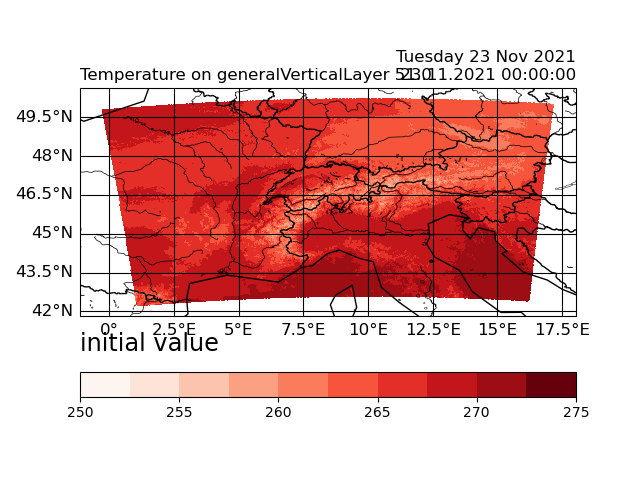

In [31]:
newfigure3 = ds_cfgrib_combi.psy.plot.mapplot(
    name="t", generalVerticalLayer=50, time=0, borders=True, cmap='Reds', rivers=True, standardtitle=True
)

In [66]:
#sp.update(lonlatbox='Switzerland')
newfigure3.update(customtext='updated text', xgrid=None, ygrid=None, rivers=True, map_extent=[5.5, 11.0, 45.5, 48.0])

In [33]:
newfigure3.update(lakes=False)

In [34]:
newfigure3.update(standardtitle=True)

In [35]:
newfigure3.update(title=(f"{ds_cfgrib_combi.t.attrs['GRIB_name']} on "
                        f"{ds_cfgrib_combi.t.attrs['GRIB_typeOfLevel']} " 
                        f"%({ds_cfgrib_combi.t.attrs['GRIB_typeOfLevel']})s "
                        f"at %(time)s \n "                         
                         '%A %e %b %Y \n'
                         '%d.%m.%Y %H:%M:%S'
                        )
                )

In [36]:
#newfigure3.close()

In [37]:
ds_cfgrib_combi

<xarray.Dataset>
Dimensions:               (time: 1, ncells: 1028172, generalVerticalLayer: 80, depthBelowLandLayer: 8, depthBelowLand: 9, generalVertical: 81, vertices: 3)
Coordinates: (12/26)
    number                int64 1
    init_time             datetime64[ns] 2021-11-23
    step                  timedelta64[ns] 00:00:00
    surface               float64 0.0
  * time                  (time) datetime64[ns] 2021-11-23
    isobaricLayer         float64 0.0
    ...                    ...
  * generalVertical       (generalVertical) float64 1.0 2.0 3.0 ... 80.0 81.0
    clon                  (ncells) float32 -0.003694 -0.003783 ... 0.2608 0.2607
    clat                  (ncells) float32 0.8636 0.8635 0.8632 ... 0.868 0.8679
    clat_bnds             (ncells, vertices) float32 0.8635 0.8637 ... 0.8678
    clon_bnds             (ncells, vertices) float32 -0.003566 ... 0.2605
  * ncells                (ncells) int64 0 1 2 3 ... 1028169 1028170 1028171
Dimensions without coordinates: vertices
Data variables: (12/70)
    snfalb                (time, ncells) float32 0.07 0.07 ... 0.1171 0.1179
    lhtfl                 (time, ncells) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    nlwrf                 (time, ncells) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    dlwrf                 (time, ncells) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ulwrf                 (time, ncells) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    shtfl                 (time, ncells) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...                    ...
    sd                    (time, ncells) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    W_SO                  (time, depthBelowLandLayer, ncells) float32 0.0 ......
    W_SO_ICE              (time, depthBelowLandLayer, ncells) float32 0.0 ......
    wz                    (time, generalVertical, ncells) float32 -0.009946 ....
    THHR_RAD              (time, generalVerticalLayer, ncells) float32 1.237e...
    SOHR_RAD              (time, generalVerticalLayer, ncells) float32 0.0 .....
Attributes:
    GRIB_edition:            2
    GRIB_centre:             lssw
    GRIB_centreDescription:  Zurich
    GRIB_subCentre:          255
    Conventions:             CF-1.7
    institution:             Zurich
    history:                 2022-01-25T16:18 GRIB to CDM+CF via cfgrib-0.9.9...

## 4.0 Combined Mapplot - Wind + Temperature

/scratch/vcherkas/envs/psyplot/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/scratch/vcherkas/envs/psyplot/lib/python3.8/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/scratch/vcherkas/envs/psyplot/lib/python3.8/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/scratch/vcherkas/envs/

TypeError: 'bool' object is not subscriptable

/scratch/vcherkas/envs/psyplot/lib/python3.8/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


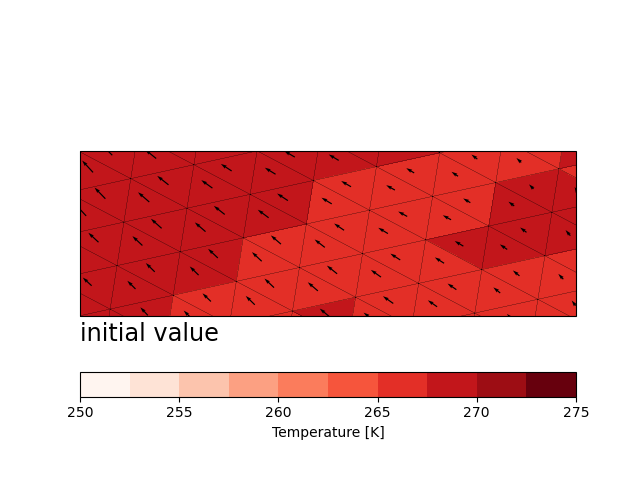

In [38]:
newfigure4 = ds_cfgrib_combi.psy.plot.mapcombined(
            name=[['t',['u','v']]], 
            generalVerticalLayer=50, time=0, datagrid={'c': 'k', 'lw': 0.1}, xgrid=None, ygrid=None,
            borders=True, 
            cmap='Reds', 
            arrowsize=100, 
            vcbar='r',
            clabel='{desc}', 
            vclabel='Wind Speed [%(units)s]',
            map_extent=[6.85, 7.0, 46.7, 46.75]
            )

### Remap ICON grid to Regular grid for wind plotting

 # grid created from scratch:
 #    corner 1           :    5.000  45.000
 #    corner 2           :   11.000  47.000
 #    pole               : -180.000  90.000
 #    nxpoints, nypoints :          100         100
 # input field 'U' -> 'U'
 #     interpolation : rbf: scalar
 # input field 'T' -> 'T'
 #     interpolation : rbf: scalar
 # input field 'V' -> 'V'
 #     interpolation : rbf: scalar
 #
 # Interpolation statistics:
 #     min. distance to source data point:   0.000 (rad)
 #     avg. distance to source data point:   0.000 (rad)
 #     max. distance to source data point:   0.000 (rad)
 #
 # RBF-Direct: 10000; RBF-QR: 0 out of 10000 destination points (cells).
 # min/max shape parameter:    195.04274359055393        198.31123413472494     
 # Done.
/scratch/vcherkas/envs/psyplot/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property ins

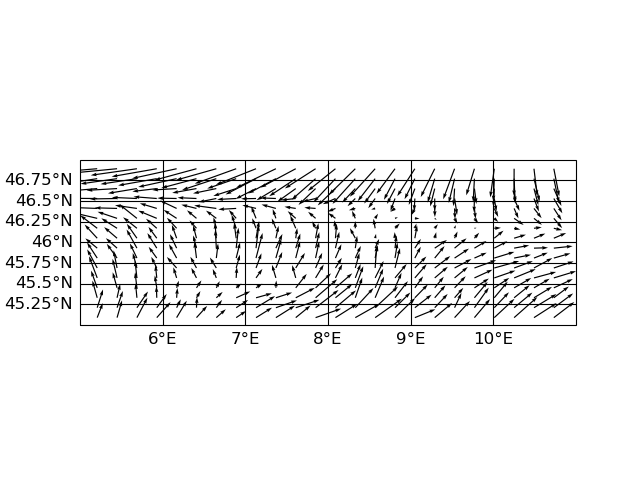

In [67]:
from utils import ICONtoReg 

f_icon_nc = '/scratch/walser/icon-vis/icon-1/21112300.nc/lfff00000000z'
f_icon_nc_grid = '/scratch/cmerker/data/icon_grid/icon_grid_0001_R19B08_L.nc'

output_file = ICONtoReg.remap_ICON_to_Regulargrid(data_file=f_icon_nc, 
                            grid_file=f_icon_nc_grid, 
                            init_type="netcdf2")

mapvectors = psy.plot.mapvector(output_file, time=0,
                                map_extent=[5., 11.0, 45., 47.0], 
                                name=[['U', 'V']],
                                density=15, arrowsize=100)

## Appendix
### Notes to consider with psyplot

 *  _NETCDF_ note: If your .nc file is missing the grid-information, this has to be added (merged) from the grid-file which had been used to run the simulation. This would be the case if you ran icon with the output_nml:output_grid flag set to .FALSE. (which appears to be the default ICON setting).

* It may also be necessary in this case to add coordinates encoding to the variable you want to plot eg. for athb_s: `ds.athb_s.encoding.update(coordinates="clon clat")`


### Open Questions 